In [1]:
import pandas as pd
import numpy as np
import nltk
import random
import time
import string
import collections
import matplotlib.pyplot as plt
import calendar
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from copy import copy, deepcopy
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from pandas.tseries.offsets import *
from datetime import datetime
from calendar import monthrange
from dateutil import relativedelta
from datetime import datetime, timedelta
lmtzr=WordNetLemmatizer()

In [2]:
data_ads = "/Users/MaxTan/Documents/CU_16fall/BDA/Project/Data/"

user_raw = pd.read_csv(data_ads + "wow3_user2.csv", names = ["user_id", "review_count", "average_stars", 
                                               "friends", "fans", "votes_cool", "votes_funny", 
                                               "votes_useful", "num", "degree", "coefficient"])

business_raw = pd.read_csv(data_ads+"wow3_business_mysql.csv", names = ["business_id", "name", "latitude", 
                                                           "longitude", "stars", "categories", 
                                                           "review_count", "open"])

review_raw = pd.read_csv(data_ads+"wow3_review_mysql.csv", names = ["review_id", "user_id", "business_id", 
                                                       "stars", "text", "date", "votes_funny", 
                                                       "votes_useful"])

all_raw = pd.read_csv(data_ads+"wow3_all2.csv", names = ["business_id", 
                                                       "name", "stars_business","business_review_count",
                                                       "categories", "open", "review_id", 
                                                       "stars_review", "text", "date", "votes_funny", 
                                                       "votes_useful","user_id", "user_review_count", 
                                                       "average_stars","friends", "fans", "num", 
                                                       "degree", "coefficient"])


/Users/MaxTan/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#3. Business Rate Prediction(Time Series):
#Input: a given business_id
#Output: predicted result of next month's rate and model data visualization

In [4]:
#Choose a business ID to create a sub-data-frame:
temp_biz = collections.Counter(all_raw.business_id.values).most_common(10)[0][0]
#temp_biz = "-Mh44q324VW8mpxIdH_HPw"

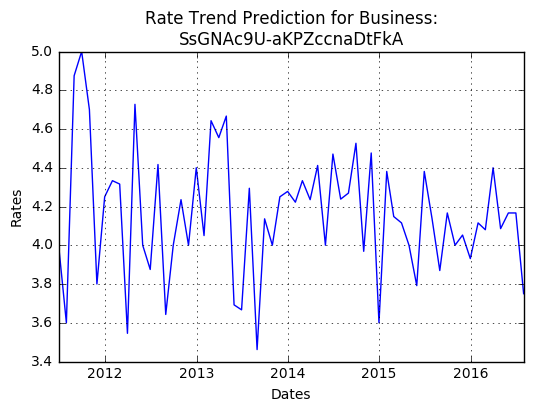

/Users/MaxTan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:62: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
/Users/MaxTan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:69: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
/Users/MaxTan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:70: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()


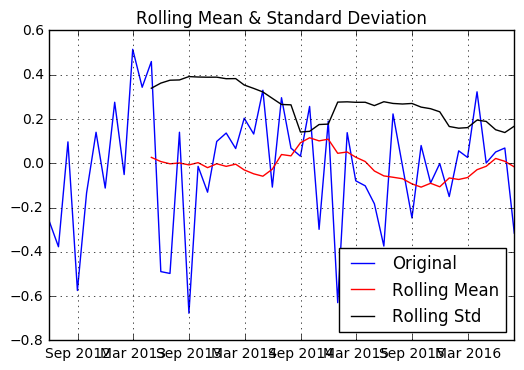

Results of Dickey-Fuller Test:
Test Statistic                 -4.086234
p-value                         0.001021
#Lags Used                      5.000000
Number of Observations Used    45.000000
Critical Value (5%)            -2.928299
Critical Value (1%)            -3.584829
Critical Value (10%)           -2.602344
dtype: float64


/Users/MaxTan/anaconda/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


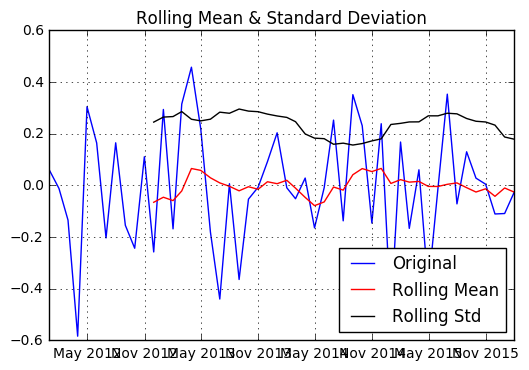

Results of Dickey-Fuller Test:
Test Statistic                 -4.583920
p-value                         0.000138
#Lags Used                      5.000000
Number of Observations Used    44.000000
Critical Value (5%)            -2.929886
Critical Value (1%)            -3.588573
Critical Value (10%)           -2.603185
dtype: float64


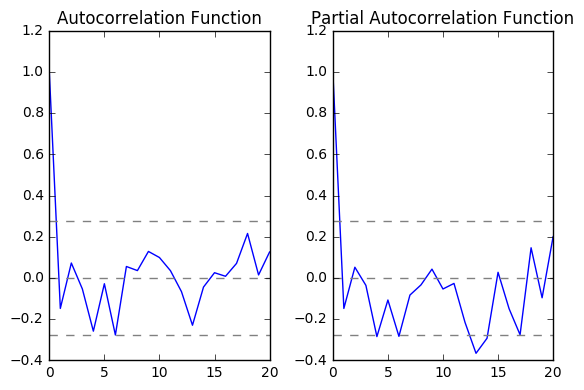

/Users/MaxTan/anaconda/lib/python2.7/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


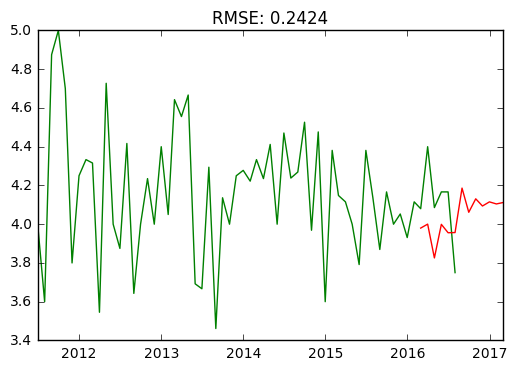

The true data is 
                rate
2011-06-30  4.000000
2011-07-31  3.600000
2011-08-31  4.875000
2011-09-30  5.000000
2011-10-31  4.700000
2011-11-30  3.800000
2011-12-31  4.250000
2012-01-31  4.333333
2012-02-29  4.315789
2012-03-31  3.545455
2012-04-30  4.727273
2012-05-31  4.000000
2012-06-30  3.875000
2012-07-31  4.416667
2012-08-31  3.642857
2012-09-30  4.000000
2012-10-31  4.235294
2012-11-30  4.000000
2012-12-31  4.400000
2013-01-31  4.050000
2013-02-28  4.642857
2013-03-31  4.555556
2013-04-30  4.666667
2013-05-31  3.692308
2013-06-30  3.666667
2013-07-31  4.294118
2013-08-31  3.461538
2013-09-30  4.136364
2013-10-31  4.000000
2013-11-30  4.250000
...              ...
2014-02-28  4.333333
2014-03-31  4.235294
2014-04-30  4.411765
2014-05-31  4.000000
2014-06-30  4.470588
2014-07-31  4.238095
2014-08-31  4.269231
2014-09-30  4.526316
2014-10-31  3.968750
2014-11-30  4.476190
2014-12-31  3.600000
2015-01-31  4.380952
2015-02-28  4.148148
2015-03-31  4.115385
2015-04-30  4.00

In [5]:
sub_biz = all_raw[all_raw['business_id']==temp_biz]

if sub_biz.shape[0]<200:
    raise ValueError('could not find enough review data for %s' % temp_biz)
sub_biz.head(1)


dates = [datetime.strptime(date,'%Y-%m-%d') for date in sub_biz.date.values]
rate_predict = pd.DataFrame()
rate_predict['rate'] = pd.Series(sub_biz.stars_review.values,index = pd.Series(dates))

plt.plot_date(x=rate_predict.index.values, y=rate_predict.rate.values,fmt='r*')
plt.title('Rate Trend Prediction')
plt.ylabel('Rates')
plt.xlabel('Dates')
plt.grid(True)
#plt.show()
plt.close()


#Aggregation: group by month and take average
g = rate_predict.groupby(pd.TimeGrouper("M"))
rate_predict_avg = g.mean()
plt.plot_date(x=rate_predict_avg.index, y=rate_predict_avg.rate.values,fmt='b-')
plt.title('Rate Trend Prediction for Business:\n'+ temp_biz)
plt.ylabel('Rates')
plt.xlabel('Dates')
plt.grid(True)
plt.show()
plt.close()


if rate_predict_avg.shape[0]<36:
    raise ValueError('could not find enough review data for %s' % temp_biz)
    
      
start = rate_predict_avg.index[0]
end = rate_predict_avg.index[-1]


def calculate_monthdelta(date1, date2):
    def is_last_day_of_the_month(date):
        days_in_month = calendar.monthrange(date.year, date.month)[1]
        return date.day == days_in_month
    imaginary_day_2 = 31 if is_last_day_of_the_month(date2) else date2.day
    monthdelta = (
        (date2.month - date1.month) +
        (date2.year - date1.year) * 12 +
        (-1 if date1.day > imaginary_day_2 else 0)
        )
    return monthdelta

#Check:
#print calculate_monthdelta(start,end)+1,rate_predict_avg.shape[0]




months = rate_predict_avg.shape[0]

#1.Rolling mean(Moving Average) of the monthly prediction:
moving_avg = pd.rolling_mean(rate_predict_avg,12)

rate_predict_moving_avg_diff = rate_predict_avg - moving_avg


def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid(True)
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries.values.ravel(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    
    
#Drop NA for Moving Average:
rate_predict_moving_avg_diff.dropna(inplace=True)
#Perform Stationarity Test:
test_stationarity(rate_predict_moving_avg_diff)


#3.Decomposition:

rate_predict_avg = rate_predict_avg.fillna(method = 'bfill')


decomposition = seasonal_decompose(rate_predict_avg)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

"""
plt.subplot(411)
plt.plot(rate_predict_avg, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
"""

rate_predict_decompose = residual
rate_predict_decompose.dropna(inplace=True)
test_stationarity(rate_predict_decompose)




lag_acf = acf(rate_predict_decompose, nlags=20)
lag_pacf = pacf(rate_predict_decompose, nlags=20, method='ols')


plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(rate_predict_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(rate_predict_decompose)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(rate_predict_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(rate_predict_decompose)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()


model = ARIMA(rate_predict_avg, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  


plt.plot(rate_predict_decompose,color = 'green')
plt.plot(results_AR.fittedvalues, color = 'red')



#plt.show()
plt.close()




predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)

predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()

predictions_AR = pd.Series(rate_predict_avg.values[0], index=rate_predict_avg.index)
predictions_AR = predictions_AR.add(predictions_AR_diff_cumsum,fill_value=0)


short_predict = results_AR.predict(start = months-6,end = months+6)

short_predict_AR_diff = pd.Series(short_predict, copy=True)

short_predict_AR_diff_cumsum = short_predict_AR_diff.cumsum()



short_predict_AR = pd.Series(rate_predict_avg[rate_predict_avg.index==short_predict.index[0]].rate.values[0], index=short_predict.index)
short_predict_AR = short_predict_AR.add(short_predict_AR_diff_cumsum,fill_value=0)



plt.plot(rate_predict_avg,color='green')

plt.plot(short_predict_AR,color = 'red')

res = 0.0
n = len(short_predict_AR.iloc[:6].values)
for i in range(n):
    res +=(short_predict_AR.iloc[:6].values[i]-rate_predict_avg.iloc[-6:].values[i])**2
res/=n
RMSE = np.sqrt(res[0])

plt.title('RMSE: %.4f'% RMSE)
plt.show()
plt.close()


print "The true data is "
print rate_predict_avg

print "The predicted data is"
print short_predict_AR

In [6]:
print results_AR.summary()

                             ARIMA Model Results                              
Dep. Variable:                 D.rate   No. Observations:                   61
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -29.633
Method:                       css-mle   S.D. of innovations              0.392
Date:                Thu, 22 Dec 2016   AIC                             65.266
Time:                        00:07:55   BIC                             71.598
Sample:                    07-31-2011   HQIC                            67.747
                         - 07-31-2016                                         
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            0.0007      0.033      0.020      0.984        -0.063     0.065
ar.L1.D.rate    -0.5483      0.107     -5.142      0.000        -0.757    -0.339
                                    Roots   

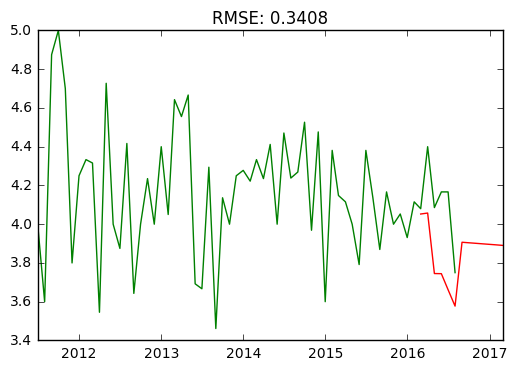

In [7]:
model = ARIMA(rate_predict_avg, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  

plt.plot(rate_predict_decompose,color = 'green')
plt.plot(results_MA.fittedvalues, color = 'red')



#plt.show()
plt.close()




predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)

predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()

predictions_MA = pd.Series(rate_predict_avg.values[0], index=rate_predict_avg.index)
predictions_MA = predictions_MA.add(predictions_MA_diff_cumsum,fill_value=0)


short_predict = results_MA.predict(start = months-6,end = months+6)

short_predict_MA_diff = pd.Series(short_predict, copy=True)

short_predict_MA_diff_cumsum = short_predict_MA_diff.cumsum()


short_predict_MA = pd.Series(rate_predict_avg[rate_predict_avg.index==short_predict.index[0]].rate.values[0], index=short_predict.index)
short_predict_MA = short_predict_MA.add(short_predict_MA_diff_cumsum,fill_value=0)



plt.plot(rate_predict_avg,color='green')

plt.plot(short_predict_MA,color = 'red')

res = 0.0
n = len(short_predict_MA.iloc[:6].values)
for i in range(n):
    res +=(short_predict_MA.iloc[:6].values[i]-rate_predict_avg.iloc[-6:].values[i])**2
res/=n
RMSE = np.sqrt(res[0])

plt.title('RMSE: %.4f'% RMSE)
plt.show()
plt.close()

In [8]:
print results_MA.summary()

                             ARIMA Model Results                              
Dep. Variable:                 D.rate   No. Observations:                   61
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -19.493
Method:                       css-mle   S.D. of innovations              0.322
Date:                Thu, 22 Dec 2016   AIC                             44.986
Time:                        00:07:59   BIC                             51.318
Sample:                    07-31-2011   HQIC                            47.467
                         - 07-31-2016                                         
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           -0.0027      0.002     -1.187      0.240        -0.007     0.002
ma.L1.D.rate    -1.0000      0.045    -22.333      0.000        -1.088    -0.912
                                    Roots   

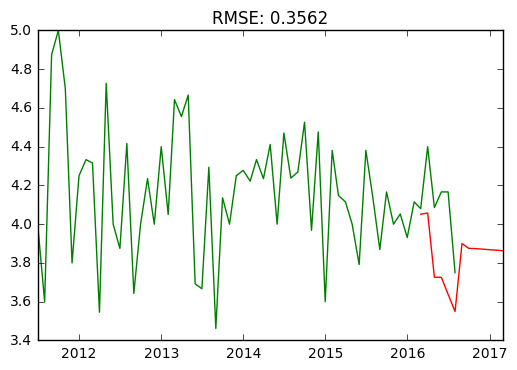

In [9]:
model = ARIMA(rate_predict_avg, order=(1, 1, 1))  

results_ARMA = model.fit(disp=-1)  


plt.plot(rate_predict_decompose,color = 'green')
plt.plot(results_ARMA.fittedvalues, color = 'red')




#plt.show()
plt.close()




predictions_ARMA_diff = pd.Series(results_ARMA.fittedvalues, copy=True)

predictions_ARMA_diff_cumsum = predictions_ARMA_diff.cumsum()

predictions_ARMA = pd.Series(rate_predict_avg.values[0], index=rate_predict_avg.index)
predictions_ARMA = predictions_ARMA.add(predictions_ARMA_diff_cumsum,fill_value=0)


short_predict = results_ARMA.predict(start = months-6,end = months+6)

short_predict_ARMA_diff = pd.Series(short_predict, copy=True)

short_predict_ARMA_diff_cumsum = short_predict_ARMA_diff.cumsum()



short_predict_ARMA = pd.Series(rate_predict_avg[rate_predict_avg.index==short_predict.index[0]].rate.values[0], index=short_predict.index)
short_predict_ARMA = short_predict_ARMA.add(short_predict_ARMA_diff_cumsum,fill_value=0)



plt.plot(rate_predict_avg,color='green')

plt.plot(short_predict_ARMA,color = 'red')

res = 0.0
n = len(short_predict_ARMA.iloc[:6].values)
for i in range(n):
    res +=(short_predict_ARMA.iloc[:6].values[i]-rate_predict_avg.iloc[-6:].values[i])**2
res/=n
RMSE = np.sqrt(res[0])

plt.title('RMSE: %.4f'% RMSE)
plt.show()
plt.close()

In [10]:
print results_ARMA.summary()

                             ARIMA Model Results                              
Dep. Variable:                 D.rate   No. Observations:                   61
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -19.376
Method:                       css-mle   S.D. of innovations              0.321
Date:                Thu, 22 Dec 2016   AIC                             46.752
Time:                        00:08:01   BIC                             55.196
Sample:                    07-31-2011   HQIC                            50.061
                         - 07-31-2016                                         
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           -0.0027      0.002     -1.258      0.213        -0.007     0.002
ar.L1.D.rate    -0.0626      0.129     -0.484      0.630        -0.316     0.191
ma.L1.D.rate    -0.9999      0.046    -21.94